# Pull a small set of data and overfit on it

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

import numpy as np
import timeit

# Return dataloaders for train, test, and val
def load_images(train_df, test_df, val_df, hasTest=True):
    loader_train = None
    loader_test = None
    loader_val = None
    
    # load the image files and store as 3-channel tensors
    
    
    # create the dataloaders
    train = data_utils.TensorDataset(X, y)
    loader_train = DataLoader(train, batch_size=64, shuffle=True)

    if hasTest:
        test = data_utils.TensorDataset(X, y)
        loader_test = DataLoader(test, batch_size=64, shuffle=True)
    
    val = data_utils.TensorDataset(X, y)
    loader_val = DataLoader(val, batch_size=64, shuffle=True)    
    
    return [loader_train, load_test, loader_val]


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

dtype = torch.FloatTensor
gpu_dtype = dtype # temporary
print_every = 20

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def train(model, loss_fn, optimizer, loader_train, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
def check_accuracy(model, loader):
    print('Checking accuracy!')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        y = y.view(-1, 1).type(torch.LongTensor)
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# Prep the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob

t = pd.read_csv('../data/all_data_info.csv'); t.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [10]:
# filter down to just the first set of training data
train_1 = t[t['new_filename'].str.startswith('1')]
train_1 = train_1[train_1['in_train']]

# print(train_1.shape)

# pull a random sample of 200 impressionsim and 200 realism paintings
df1 = train_1[train_1['artist'].str.startswith('Albrecht Durer', na=False)].sample(n=50)
df2 = train_1[train_1['artist'].str.startswith('Claude Monet', na=False)].sample(n=50)

# split data into train and val
train_df1 = df1.sample(n=40)
train_df2 = df2.sample(n=40)

val_df1 = df1.loc[~df1.index.isin(train_df1.index)]
val_df2 = df2.loc[~df2.index.isin(train_df2.index)]

# print(val_df1.shape)
# print(train_df1.shape)

train_df = pd.concat([train_df1, train_df2])
val_df = pd.concat([val_df1, val_df2])

print(train_df.shape)
print(val_df.shape)

# modify data to have numbers for artists and style, and create appropriate mappings
unique_artists = train_df['artist'].str.upper().unique()
unique_styles = train_df['style'].str.upper().unique()

artist_l = {val: idx for (idx, val) in enumerate(unique_artists)}
style_l = {val: idx for (idx, val) in enumerate(unique_styles)}

artist_labels = {idx: val for (idx, val) in enumerate(unique_artists)}
style_labels = {idx: val for (idx, val) in enumerate(unique_styles)}

train_df['artist_label'] = np.array([artist_l[a] for a in train_df['artist'].str.upper().values])
train_df['style_label'] = np.array([style_l[a] for a in train_df['style'].str.upper().values])

val_df['artist_label'] = np.array([artist_l[a] for a in val_df['artist'].str.upper().values])
val_df['style_label'] = np.array([style_l[a] for a in val_df['style'].str.upper().values])

(80, 12)
(20, 12)


# Display a few images by the artists


['ALBRECHT DURER' 'CLAUDE MONET']
ALBRECHT DURER
CLAUDE MONET


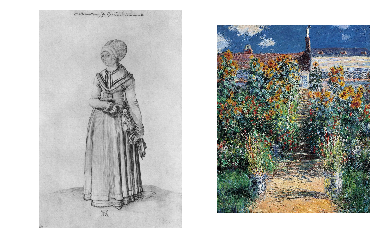

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import random
import cv2
import os, glob


artists = unique_artists
print(artists)

i_ = 1
# plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
for a in artists:
    print(a)
    artist_df = train_df[train_df['artist'].str.upper().str.startswith(a)].sample(n=1)
    for file in artist_df['new_filename']:
        img = cv2.imread('../data/train_1/' + file)
        plt.subplot(1, 2, i_)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    
        i_ += 1
plt.show()

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset

import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T

train_tensors = []
val_tensors = []

# load in imags with cv2, then convert to matrices that work with pytorch
train_transform = T.Compose([
        T.ToPILImage(),
        T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = T.Compose([
        T.ToPILImage(),
        T.Scale(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for i in train_df['new_filename']:
    # print('../data/train_1/' + i)
    img = cv2.imread('../data/train_1/' + i)
    
    # transforms and make a Tensor
    img_tensor = train_transform(img)
    train_tensors.append(img_tensor)

for i in val_df['new_filename']:
    img = cv2.imread('../data/train_1/' + i)
    
    # transforms and make a Tensor
    img_tensor = val_transform(img)
    val_tensors.append(img_tensor)
    
train_tensors = torch.stack(train_tensors)
val_tensors = torch.stack(val_tensors)

# create DataLoaders
train_labels = torch.Tensor(train_df['artist_label'].values.astype(np.float32))
val_labels = torch.Tensor(val_df['artist_label'].values.astype(np.float32))

train_dset = TensorDataset(train_tensors, train_labels)
loader_train = DataLoader(train_dset, batch_size=4, shuffle=True)
    
val_dset = TensorDataset(val_tensors, val_labels)
loader_val = DataLoader(val_dset, batch_size=4, shuffle=True)

In [73]:
# Create a simple network on our simplified dataset - should overfit it

simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # -> 112
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 56
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), # -> 28
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), # -> 14
    Flatten(),
    nn.Linear(6272, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 2),
)

simple_model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2)

In [39]:
# Now we're going to feed a random batch into the model and make sure the output is the right size
x = torch.randn(64, 3, 224, 224).type(dtype)
x_var = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = simple_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 2]))

True

In [68]:
# apply my simple network to the dataset
# reset(simple_model)
train(simple_model, loss_fn, optimizer, loader_train, num_epochs = 5)

check_accuracy(simple_model, loader_train)

Starting epoch 1 / 5
t = 20, loss = 0.0001
Starting epoch 2 / 5
t = 20, loss = 0.0000
Starting epoch 3 / 5
t = 20, loss = 0.0046
Starting epoch 4 / 5
t = 20, loss = 0.0005
Starting epoch 5 / 5
t = 20, loss = 0.0000
Checking accuracy!
Got 76 / 80 correct (95.00)
